# Monte Carlo Simulations & Missing Values

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

---
## Markov Chain Monte-Carlo: The Metropolis Algorithm

Markov Chain Monte-Carlo (MCMC) methods, are techniques for sampling based on random walks. In other words, MCMC is a class of techniques for sampling from a probability distribution and can be used to estimate the distribution of parameters given a set of observations.

The Metropolis-Hastings algorithm is a technique to sample from high dimensional, difficult to sample distributions or functions. It is often used for cases where direct sampling is not feasible due to intractable integrals. It's a MCMC algorithm - Markov Chain because the next sample $x'$ only relies on the current sample $x$, and Monte Carlo because it generates a random sample which can be used to e.g., compute integrals. 

The key ingredient in this technique lies in the distribution $g(x \rightarrow x')$, which is used to compute the next candidate of the Markov Chain from a given state. From this, the *acceptance probability* $\alpha$ is calculated. It is the probability that is used to decide whether the new sample is accepted or not, and is given by $\alpha = min(1, \frac{f(x')}{f(x)} \frac{g(x' \rightarrow x)}{g(x \rightarrow x')})$, where $f(x)$ is a function that is proportional to the target distribution $P(x)$ we want to sample from. If the transition distribution is symmetric such that $g(x \rightarrow x') = g(x' \rightarrow x)$, then the algorithm is just called Metroplis, and the second factor in the equation for $\alpha$ is unity. This is true, for example, if $g$ is Gaussian.


First we build a function that performs MCMC to sample a 2D target distribution. Then we use the *metropolis* function you just implemented to draw $10^5$ samples from a multivariate Gaussian with (2D) mean $\mu=[2,2]$ and covariance matrix given by:
    \begin{pmatrix}
        1 & 0.5\\
        0.5 & 1
    \end{pmatrix}


In [4]:
def metropolis(f, x0=0, y0=0, iterations=1000):
    ''' Metropolis algorithm.
    
    Args:
        f (function): Function that is proportional
                      to the target distribution.
        x0, y0 (floats): Coordinates of the starting point
        iterations (int): Number of iterations
    
    Returns:
        samples: Array filled with the drawn samples.
    
    '''
    # TO-DO: Initialize x and y for the starting point
    x, y = x0, y0
    
    # TO-DO: Define an array to store your samples
    samples = np.zeros((iterations,2))
    
    for i in range(iterations):
        # what is a transition matrix
        # TO-DO: Propose a new point, with a Gaussian as transition distribution
        x_prime, y_prime = np.random.normal(loc = x), np.random.normal(loc = y)
        
        # TO-DO: Implement the acceptance condition
        A = f(x_prime, y_prime) / f(x,y)  # should be min(1, x_prime, f(x_prime, y_prime) / f(x,y ))
        accept =  np.random.normal() < A # is not correct
        if accept: x, y = x_prime, y_prime
        
        # TO-DO: Store the sample
        samples[i] = [x,y]
        
    return samples

In [5]:
# Multivariate Gaussian
def multivariate_gauss(x, y, mu= np.array([2,2]), cov= np.array([[1, .5], [.5, 1]])):
    return (stats.multivariate_normal.pdf([x, y], mean=mu, cov=cov))


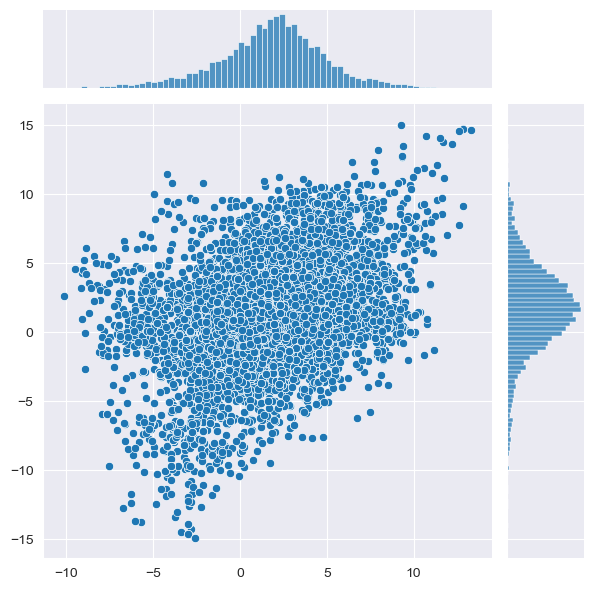

In [6]:
# We use metropolis to sample from a the multivariate gaussian...
samples = metropolis(multivariate_gauss, iterations=10000)

# ...and plot the samples
sns.jointplot(x = samples[:,0], y = samples[:,1])

---

What are the main advantages and disadvantages of MCMC sampling?

- **Advantage:** Less correlated samples with high acceptance rates.
- **Disadvantage:** Only easily applicable if the exploratory variable is continuous.

---

## PyMC3 - a library for mcmc-sampling

bayes theorem in shortly simpler version:
  
$$p(\theta|x, y) \propto p(\theta)\cdot p(x, y|\theta)$$
  
i.e. the posterior distribution of parameters $\theta$ is proportional to the prior and the likelihood of our data sample. We can use this formalism to solve a linear regression problems. Let us assume our fitting parameters are $\theta = (q, s, \sigma)$ where $q$ is the intercept, $s$ the slope and $\sigma$ the intrinsic scatter of $y$.
Furthermore let us assume that our observed $y$ is normally distributed around the true regression relation.
The **likelihood** of our datasample is then easily computed (see lecture notes).  
The **prior** function encapsulates all information we believe to have about the fitting parameters before having seen any data! E.g. these can be realistic ranges within which we expect our parameters to be.  
  
What we want is to sample from the posterior distribution (which in real world examples can be very complicated!). Once we have a good idea how this distribution looks for each parameter we can compute the expected parameter fitting values (mean) as well as the error (standard deviation) on them.

In your daily life as a data scientist, we might not want to implement mcmc-sampling yourself. Luckily, the **pymc3** (documentation: [https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/api_quickstart.html]) module has all the functionalities we might want to perform mcmc. What follows is the general usage of the module presented with an example of fitting a straight line using parameter estimates coming from an mcmc-algorithm.

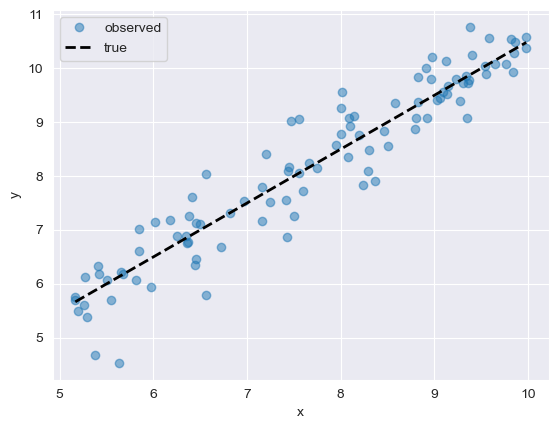

In [7]:
def model(x, theta=[1,0]):
    '''
    A simple linear model
    '''
    slope, intercept = theta
    y = slope*x + intercept
    return y

# True parameters: slope, intercept, noise
slope_true = 1
intercept_true = .5
eps_true = .5

# Observations
N_obs = 100
x_obs = np.sort(5*np.random.rand(N_obs)) + 5
y_true = model(x_obs, theta=[slope_true,intercept_true])
y_obs = y_true + np.random.normal(loc=0, scale=eps_true, size=N_obs)

# Plot
_ = plt.plot(x_obs, y_obs, 'o', alpha=.5, label='observed')

x = np.linspace(x_obs.min(), x_obs.max(), 100)
y = model(model(x, theta=[slope_true,intercept_true]))
_ = plt.plot(x, y, '--k', lw=2, label='true')

_ = plt.xlabel('x')
_ = plt.ylabel('y')
_ = plt.legend()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [slope]
>Metropolis: [Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 182 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Intercept: 1.192 ± 0.287
slope: 0.911 ± 0.037
sigma: 0.510 ± 0.037


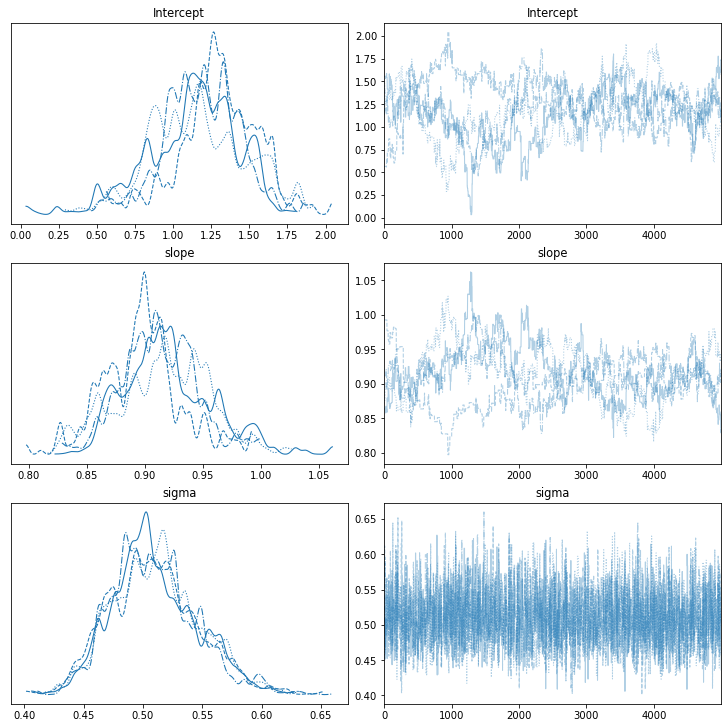

In [7]:
import pymc3 as pm

with pm.Model() as linear_model: # Consider linear model
    # Priors for the parameters: slope, intercept, and scatter
    prior_intercept = pm.Normal('Intercept', mu=0, sd=1)
    prior_slope     = pm.Normal('slope', mu=0, sd=1)
    prior_sigma     = pm.HalfNormal('sigma', sd=0.5)

    # Likelihood
    prior_mean  = prior_intercept + prior_slope * x_obs
    Y_obs = pm.Normal('Y_obs', mu=prior_mean, sd=prior_sigma, observed=y_obs)

    # Sample the posterior with MCMC
    chain = pm.Metropolis()
    # It will spend the first n_tune steps changing the step size (i.e. the sigma of the transition Gaussian)
    # trying to find the best value for it, i.e. the one that will give you a certain acceptance rate
    # (if you want to set different acceptance rates, please t)
    linear_trace = pm.sample(5000, chain, tune=1000)

# Estimated parameters for the linear model
intercepts = linear_trace['Intercept']
slopes = linear_trace['slope']
sigmas = linear_trace['sigma']

print(f'Intercept: {intercepts.mean():.3f} ± {intercepts.std():.3f}')
print(f'slope: {slopes.mean():.3f} ± {slopes.std():.3f}')
print(f'sigma: {sigmas.mean():.3f} ± {sigmas.std():.3f}')

# Show the results
_ = pm.traceplot(linear_trace, figsize=(10,10))

# We have both the best fitting line and the posterior distributions for our parameters!


- Similarly to the example above, we create a dataset of $N_{\rm obs}=200$ uniformly distributed observations of a feature  $x$, spanning from 10 to 20, and a outcome $y\left(x\right) = 5 x + 1$. We also add an intrinsic gaussian scatter $\epsilon=0.3$ on the measure of $y$.
- Then we estimate the parameters of the true underlying linear relation between $x$ and $y$, using the Metropolis algorithm. We report the slope and intercept best estimates, together with their error and their posterior distributions. (See the example above to guide you in using pymc3 to carry out this task).
- Finally, we perform linear regression to estimate the true slope and intercept. Report the best estimates for these parameters and compare them with the ones obtained by means of MCMC. Then we plot the observed data ($x$ vs $y$ scatter plot), the true relation, the MCMC-estimated relation, and the one estimated via ordinary regression.

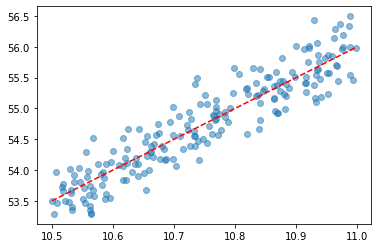

In [17]:
intercept_true = 1
slope_true = 5
eps_true  = .3

N_obs = 200
x_obs = np.sort(.05 * np.random.uniform(10,20,N_obs)) + 10
y_true = model(x_obs, theta = [slope_true, intercept_true])
y_obs = y_true + np.random.normal(loc = 0, scale = eps_true, size = N_obs )

# for overview

plt.scatter(x_obs,y_obs, alpha = .5) # better overview
plt.plot(x_obs, y_true, '--', color = 'red')

In [34]:
# We estimate slope and intercept using MCMC

with pm.Model() as linear_model:
    prior_intercept = pm.Normal('Intercept', mu = 1, sd = 1) # mus == true params
    prior_slope = pm.Normal('Slope', mu = 5, sd  = 1)
    prior_sigma = pm.HalfNormal('Sigma', sd = 0.3)
    
    # likelihood
    prior_mean = prior_intercept + prior_slope * x_obs
    x_obs
    Y_obs = pm.Normal('Y_obs', mu=prior_mean, sd=prior_sigma, observed=y_obs)
    
    algorithm = pm.Metropolis()
    linear_trace = pm.sample(5000, algorithm)
    
intercepts = linear_trace['Intercept']
slopes = linear_trace['Slope']
sigmas = linear_trace['Sigma']

print(f'Intercept: {intercepts.mean():.3f} ± {intercepts.std():.3f}')
print(f'Slope: {slopes.mean():.3f} ± {slopes.std():.3f}')
print(f'Sigma: {sigmas.mean():.3f} ± {sigmas.std():.3f}')

_ = pm.traceplot(linear_trace, figsize=(10,10))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Sigma]
>Metropolis: [Slope]
>Metropolis: [Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 538 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Intercept: 1.091 ± 0.555
Slope: 4.993 ± 0.052
Sigma: 0.288 ± 0.014


In [47]:
# We estimate slope and intercept using ordinary linear regression (see previous exercises...)

import statsmodels.formula.api as sm

df = pd.DataFrame({'x': x_obs, 'y': y_obs})

lm = sm.ols(formula = 'y ~ x', data = df).fit()
intercept_ols, slope_ols = lm.params

print(f'Intercept: {intercept_ols:.3f}')
print(f'Slope: {slope_ols:.3f}')

Intercept: -0.159
Slope: 5.110


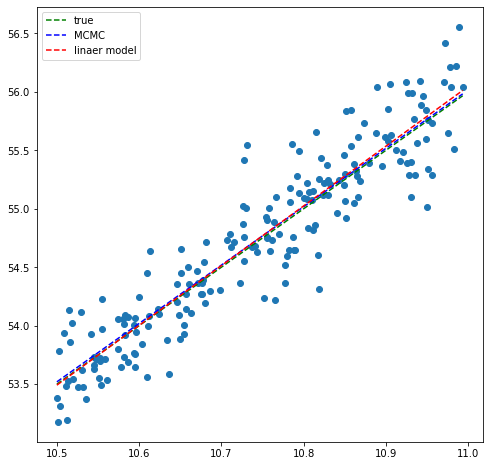

In [50]:
# Here, we compare the results  # plot like scatter obove (true, MCMC, linear model)

fig, ax = plt.subplots(1, figsize = (8,8))

ax.scatter(x_obs,y_obs)
ax.plot(x_obs, y_true,'--',color = 'green', label = 'true')
ax.plot(x_obs, model(x_obs, theta = [np.mean(slopes), np.mean(intercepts)]),'--', color = 'blue', label = 'MCMC')
ax.plot(x_obs, model(x_obs, theta = [slope_ols, intercept_ols]), '--', color = 'red', label = 'linaer model')
ax.legend()
        
                     
